Daniel Brai Gonzales Marcos             CP3013375

Giovanna Nascimento Antonieti           CP3013383

In [37]:
!pip3 install matplotlib numpy scikit-learn pandas keras tensorflow tensorflow-gpu 
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import tarfile
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from keras.applications import vgg16
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Activation, Flatten,  Conv2D, MaxPooling2D
import os
import urllib.request
import numpy as np
import tensorflow as tf
tf.config.run_functions_eagerly(True)

You should consider upgrading via the 'G:\Documents\especializacao\env_analise\Scripts\python.exe -m pip install --upgrade pip' command.


# Base de dados

O conjunto de dados CIFAR-10 consiste em 60.000 imagens coloridas de 32x32 em 10 classes, com 6.000 imagens por classe. Existem 50.000 imagens de treinamento e 10.000 imagens de teste. As classes são totalmente exclusivas entre si. Não há sobreposição entre automóveis e caminhões, por exemplo. 
As 10 classes presentes nessa base são: avião, automóvel, pássaro, veado, gato, cachorro, sapo, cavalo, navio e caminhão.

In [2]:
def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

# CIFAR-10

download('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz')

In [3]:
# open file
file = tarfile.open('cifar-10-python.tar.gz')
  
# extracting file
file.extractall('./images')
  
file.close()

In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [5]:
batch1 = unpickle('./images/cifar-10-batches-py/data_batch_1')
batch2 = unpickle('./images/cifar-10-batches-py/data_batch_2')
batch3 = unpickle('./images/cifar-10-batches-py/data_batch_3')
batch4 = unpickle('./images/cifar-10-batches-py/data_batch_4')
batch5 = unpickle('./images/cifar-10-batches-py/data_batch_5')
batches = unpickle('./images/cifar-10-batches-py/batches.meta')
test = unpickle('./images/cifar-10-batches-py/test_batch')

In [6]:
images = [*batch1.get(b'data') ,* batch2.get(b'data'), * batch3.get(b'data'), * batch4.get(b'data'),* batch5.get(b'data')]
images[0]

array([ 59,  43,  50, ..., 140,  84,  72], dtype=uint8)

In [7]:
labels = [*batch1.get(b'labels') ,* batch2.get(b'labels'), * batch3.get(b'labels'), * batch4.get(b'labels'),* batch5.get(b'labels')]
labels

[6,
 9,
 9,
 4,
 1,
 1,
 2,
 7,
 8,
 3,
 4,
 7,
 7,
 2,
 9,
 9,
 9,
 3,
 2,
 6,
 4,
 3,
 6,
 6,
 2,
 6,
 3,
 5,
 4,
 0,
 0,
 9,
 1,
 3,
 4,
 0,
 3,
 7,
 3,
 3,
 5,
 2,
 2,
 7,
 1,
 1,
 1,
 2,
 2,
 0,
 9,
 5,
 7,
 9,
 2,
 2,
 5,
 2,
 4,
 3,
 1,
 1,
 8,
 2,
 1,
 1,
 4,
 9,
 7,
 8,
 5,
 9,
 6,
 7,
 3,
 1,
 9,
 0,
 3,
 1,
 3,
 5,
 4,
 5,
 7,
 7,
 4,
 7,
 9,
 4,
 2,
 3,
 8,
 0,
 1,
 6,
 1,
 1,
 4,
 1,
 8,
 3,
 9,
 6,
 6,
 1,
 8,
 5,
 2,
 9,
 9,
 8,
 1,
 7,
 7,
 0,
 0,
 6,
 9,
 1,
 2,
 2,
 9,
 2,
 6,
 6,
 1,
 9,
 5,
 0,
 4,
 7,
 6,
 7,
 1,
 8,
 1,
 1,
 2,
 8,
 1,
 3,
 3,
 6,
 2,
 4,
 9,
 9,
 5,
 4,
 3,
 6,
 7,
 4,
 6,
 8,
 5,
 5,
 4,
 3,
 1,
 8,
 4,
 7,
 6,
 0,
 9,
 5,
 1,
 3,
 8,
 2,
 7,
 5,
 3,
 4,
 1,
 5,
 7,
 0,
 4,
 7,
 5,
 5,
 1,
 0,
 9,
 6,
 9,
 0,
 8,
 7,
 8,
 8,
 2,
 5,
 2,
 3,
 5,
 0,
 6,
 1,
 9,
 3,
 6,
 9,
 1,
 3,
 9,
 6,
 6,
 7,
 1,
 0,
 9,
 5,
 8,
 5,
 2,
 9,
 0,
 8,
 8,
 0,
 6,
 9,
 1,
 1,
 6,
 3,
 7,
 6,
 6,
 0,
 6,
 6,
 1,
 7,
 1,
 5,
 8,
 3,
 6,
 6,
 8,
 6,
 8,
 4,
 6,
 6,


In [8]:
X_test_rgba = test.get(b'data')
y_test = test.get(b'labels')
label_names = batches.get(b'label_names')
label_names

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

In [9]:
X_train_rgba = np.array(images).reshape(50000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
X_test_rgba= np.array(X_test_rgba).reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
y_train= labels

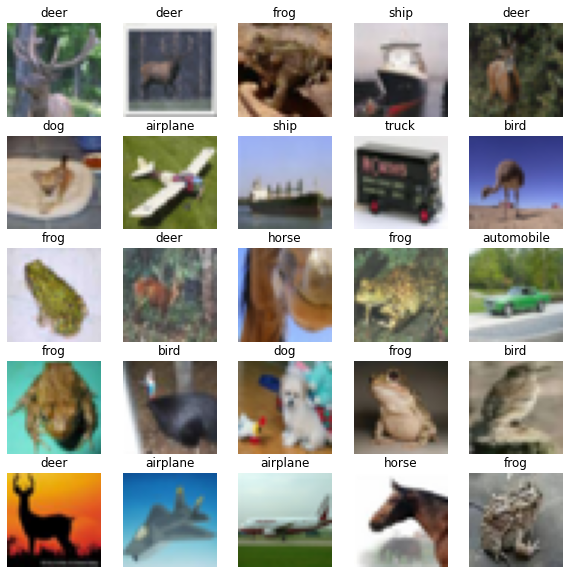

In [10]:
fig, axes1 = plt.subplots(5,5,figsize=(10,10))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X_train_rgba)))
        axes1[j][k].set_axis_off()
        axes1[j][k].title.set_text(str(label_names[labels[i]]).replace("b'"," ").replace("'"," ").strip())
        axes1[j][k].imshow(X_train_rgba[i:i+1][0])

# Distribuição das classes

<AxesSubplot:ylabel='count'>

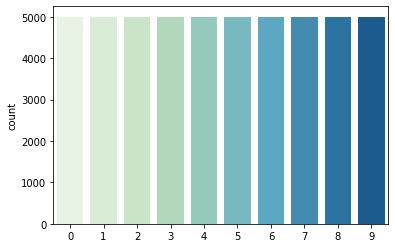

In [11]:
sns.countplot(x=labels, palette='GnBu')

# Redes Neurais

In [12]:
from tensorflow.keras.optimizers import SGD

In [13]:
batch_size = 128
epochs = 100
x_train = X_train_rgba.astype('float32')
x_test = X_test_rgba.astype('float32')
y_train = to_categorical(labels)
y_test  = to_categorical(y_test)
x_train = x_train / 255.0
x_test = x_test / 255.0

In [14]:
def summarize_diagnostics(history, filename):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.show()
    # save plot to file
    plt.savefig(filename + '_plot.png')
    plt.close()
    


O *baseline* estabelecerá um desempenho mínimo ao qual todos os modelos analisados serão comparados, além de ser um modelo que podemos utilizar como base de estudo e melhorias. Um bom ponto de partida para classificação desse conjunto de dados seriam os príncipios gerais de arquitetura dos modelos VGG [1], já que obtiveram o melhor desempenho na competição ILSVRC 2014 e porque a estrutura modular da arquitetura facilita o entendendimento e implementação. A arquitetura envolve o empilhamento de duas camadas convolucionais com pequenos filtros 3 × 3 seguidos por uma camada de *max pooling* e esses blocos podem ser repetidos onde o número de filtros em cada bloco é aumentado com a profundidade da rede. O *Padding* é usado nas camadas convolucionais para garantir que a altura e a largura dos mapas de recursos de saída correspondam às entradas. Optamos por explorar essa arquitetura no problema CIFAR-10 e comparar um modelo com essa arquitetura com um, dois e três blocos. A camada de saída deve ter 10 nós para as 10 classes e utilizaremos a função de ativação softmax.


[1]Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.

Para treinar as redes neurais que serão avaliadas utilizaremos o *stochastic gradient descendent* como otimizador, com *momentum* de 0.9 e *learning rate* de 0.0001, que são bons pontos de partida em geral. A função a ser otimizada é a entropia cruzada categórica, que é necessária para prblemas de classificação multiclasse e que monitorará a precisão da classificação

## Baseline: 1 VGG Block

In [15]:
model_vgg1 = Sequential()
model_vgg1.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_vgg1.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_vgg1.add(MaxPooling2D((2, 2)))
model_vgg1.add(Flatten())
model_vgg1.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_vgg1.add(Dense(10, activation='softmax'))
opt = SGD(lr=0.001, momentum=0.9)
model_vgg1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

g:\documents\especializacao\env_analise\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [16]:
history = model_vgg1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

g:\documents\especializacao\env_analise\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
313/313 [==============================] - 43s 137ms/step - loss: 1.9288 - accuracy: 0.3131 - val_loss: 1.7343 - val_accuracy: 0.3968
Epoch 2/100
313/313 [==============================] - 43s 138ms/step - loss: 1.6234 - accuracy: 0.4297 - val_loss: 1.5863 - val_accuracy: 0.4422
Epoch 3/100
313/313 [==============================] - 43s 137ms/step - loss: 1.4806 - accuracy: 0.4788 - val_loss: 1.4351 - val_accuracy: 0.4930
Epoch 4/100
313/313 [==============================] - 43s 139ms/step - loss: 1.3756 - accuracy: 0.5131 - val_loss: 1.3575 - val_accuracy: 0.5261
Epoch 5/100
313/313 [==============================] - 43s 137ms/step - loss: 1.2938 - accuracy: 0.5464 - val_loss: 1.3104 - val_accuracy: 0.5413
Epoch 6/100
313/313 [==============================] - 43s 136ms/step - loss: 1.2347 - accuracy: 0.5635 - val_loss: 1.2645 - val_accuracy: 0.5541
Epoch 7/100
313/313 [==============================] - 43s 136ms/step - loss: 1.1838 - accuracy: 0.5852 - val_loss: 1.2258 -

Epoch 57/100
313/313 [==============================] - 43s 136ms/step - loss: 0.0545 - accuracy: 0.9950 - val_loss: 1.6783 - val_accuracy: 0.6509
Epoch 58/100
313/313 [==============================] - 42s 136ms/step - loss: 0.0504 - accuracy: 0.9955 - val_loss: 1.7119 - val_accuracy: 0.6478
Epoch 59/100
313/313 [==============================] - 43s 136ms/step - loss: 0.0432 - accuracy: 0.9969 - val_loss: 1.7265 - val_accuracy: 0.6510
Epoch 60/100
313/313 [==============================] - 43s 136ms/step - loss: 0.0404 - accuracy: 0.9970 - val_loss: 1.7893 - val_accuracy: 0.6465
Epoch 61/100
313/313 [==============================] - 43s 136ms/step - loss: 0.0347 - accuracy: 0.9980 - val_loss: 1.7708 - val_accuracy: 0.6488
Epoch 62/100
313/313 [==============================] - 43s 137ms/step - loss: 0.0315 - accuracy: 0.9984 - val_loss: 1.8074 - val_accuracy: 0.6499
Epoch 63/100
313/313 [==============================] - 43s 137ms/step - loss: 0.0292 - accuracy: 0.9987 - val_loss: 1

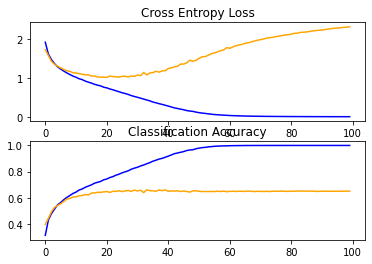

In [17]:
summarize_diagnostics(history, "onevgg")

Podemos ver que o modelo atingiu uma precisão de classificação próximo a 65% no conjunto de validação.

Com esse no gráfico da função de erro podemos observar que o desempenho do modelo no conjunto de dados de treinamento, em azul, continua a melhorar durante o processo, até estagnar próximo de 60 épocas, já no conjunto de validação, em laranja, observamos que o desempenho estagna muito antes, próximo de 15 épocas, o que indica que está ocorrendo um **overfitting**.

## Baseline: 2 VGG Blocks


In [18]:
model_vgg2 = Sequential()
model_vgg2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_vgg2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_vgg2.add(MaxPooling2D((2, 2)))
model_vgg2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_vgg2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_vgg2.add(MaxPooling2D((2, 2)))
model_vgg2.add(Flatten())
model_vgg2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_vgg2.add(Dense(10, activation='softmax'))
model_vgg2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
history=model_vgg2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/100
313/313 [==============================] - 72s 231ms/step - loss: 1.9248 - accuracy: 0.3091 - val_loss: 1.6854 - val_accuracy: 0.3930
Epoch 2/100
313/313 [==============================] - 73s 232ms/step - loss: 1.5582 - accuracy: 0.4416 - val_loss: 1.4909 - val_accuracy: 0.4674
Epoch 3/100
313/313 [==============================] - 74s 236ms/step - loss: 1.4155 - accuracy: 0.4942 - val_loss: 1.3757 - val_accuracy: 0.5146
Epoch 4/100
313/313 [==============================] - 72s 230ms/step - loss: 1.3146 - accuracy: 0.5315 - val_loss: 1.3608 - val_accuracy: 0.5218
Epoch 5/100
313/313 [==============================] - 72s 230ms/step - loss: 1.2411 - accuracy: 0.5581 - val_loss: 1.2379 - val_accuracy: 0.5672
Epoch 6/100
313/313 [==============================] - 72s 231ms/step - loss: 1.1644 - accuracy: 0.5887 - val_loss: 1.1827 - val_accuracy: 0.5828
Epoch 7/100
313/313 [==============================] - 72s 231ms/step - loss: 1.1095 - accuracy: 0.6102 - val_loss: 1.1460 -

Epoch 57/100
313/313 [==============================] - 72s 230ms/step - loss: 0.0053 - accuracy: 0.9999 - val_loss: 2.3234 - val_accuracy: 0.6778
Epoch 58/100
313/313 [==============================] - 72s 230ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 2.3668 - val_accuracy: 0.6771
Epoch 59/100
313/313 [==============================] - 72s 231ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 2.3887 - val_accuracy: 0.6787
Epoch 60/100
313/313 [==============================] - 72s 231ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 2.4162 - val_accuracy: 0.6776
Epoch 61/100
313/313 [==============================] - 72s 232ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.4399 - val_accuracy: 0.6763
Epoch 62/100
313/313 [==============================] - 72s 231ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 2.4653 - val_accuracy: 0.6769
Epoch 63/100
313/313 [==============================] - 72s 230ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 2

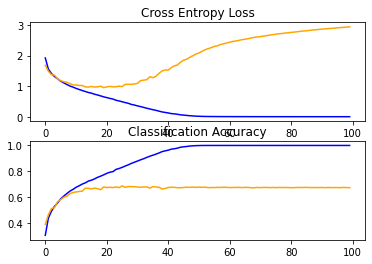

In [20]:
summarize_diagnostics(history, "twovgg")

Podemos observar que o modelo com dois blocos possui um desempenho melhor do que o modelo com um único bloco, o que é um bom sinal. Com uma acurácia acima de 67% no conjunto de validação. Com os gráficos, continuamos a ver um forte **overfitting**.

## Baseline: 3 VGG Blocks

In [21]:
model_vgg3 = Sequential()
model_vgg3.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_vgg3.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_vgg3.add(MaxPooling2D((2, 2)))
model_vgg3.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_vgg3.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_vgg3.add(MaxPooling2D((2, 2)))
model_vgg3.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_vgg3.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_vgg3.add(MaxPooling2D((2, 2)))
model_vgg3.add(Flatten())
model_vgg3.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_vgg3.add(Dense(10, activation='softmax'))
model_vgg3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history=model_vgg3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/100
313/313 [==============================] - 95s 305ms/step - loss: 1.8770 - accuracy: 0.3252 - val_loss: 1.6091 - val_accuracy: 0.4191
Epoch 2/100
313/313 [==============================] - 95s 304ms/step - loss: 1.5354 - accuracy: 0.4473 - val_loss: 1.4554 - val_accuracy: 0.4801
Epoch 3/100
313/313 [==============================] - 95s 305ms/step - loss: 1.4051 - accuracy: 0.5009 - val_loss: 1.3933 - val_accuracy: 0.5055
Epoch 4/100
313/313 [==============================] - 95s 304ms/step - loss: 1.3128 - accuracy: 0.5335 - val_loss: 1.3566 - val_accuracy: 0.5200
Epoch 5/100
313/313 [==============================] - 95s 305ms/step - loss: 1.2230 - accuracy: 0.5666 - val_loss: 1.2408 - val_accuracy: 0.5633
Epoch 6/100
313/313 [==============================] - 96s 305ms/step - loss: 1.1546 - accuracy: 0.5938 - val_loss: 1.1746 - val_accuracy: 0.5932
Epoch 7/100
313/313 [==============================] - 95s 304ms/step - loss: 1.0948 - accuracy: 0.6150 - val_loss: 1.1241 -

Epoch 57/100
313/313 [==============================] - 95s 304ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 2.4944 - val_accuracy: 0.6898
Epoch 58/100
313/313 [==============================] - 95s 304ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 2.5096 - val_accuracy: 0.6932
Epoch 59/100
313/313 [==============================] - 95s 305ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.5292 - val_accuracy: 0.6921
Epoch 60/100
313/313 [==============================] - 96s 305ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.5465 - val_accuracy: 0.6912
Epoch 61/100
313/313 [==============================] - 95s 304ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 2.5598 - val_accuracy: 0.6903
Epoch 62/100
313/313 [==============================] - 95s 305ms/step - loss: 9.5332e-04 - accuracy: 1.0000 - val_loss: 2.5762 - val_accuracy: 0.6900
Epoch 63/100
313/313 [==============================] - 95s 304ms/step - loss: 9.0591e-04 - accuracy: 1.0000 - val

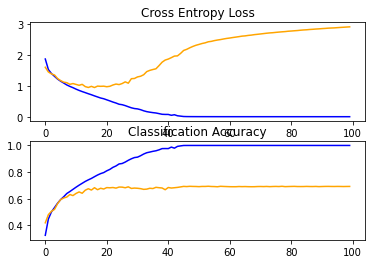

In [23]:
summarize_diagnostics(history, "threevgg")

Podemos observar mais um aumento no desempenho, conforme a profundidade do modelo é aumentada. A acurácia no conjunto de validação fica em torno de 68%. Revendo a curva de aprendizado, novamente podemos ver o **overfitting** próximo as primeiras XX épocas.

Os resultados podem ser resumidos a seguir, embora devamos supor alguma variação nesses resultados, dada a natureza estocástica do algoritmo:
* VGG 1: $\approx$ 65%
* VGG 2: $\approx$ 67%
* VGG 3: $\approx$ 69%

Em todos os casos, o modelo foi capaz de aprender o conjunto de dados de treinamento, mostrando uma melhoria no conjunto de dados de treinamento que continuou por pelo menos 40 épocas, ou talvez mais. Este é um bom sinal, pois mostra que o problema pode ser aprendido e que todos os três modelos têm capacidade suficiente para aprender o problema.

Os resultados do modelo no conjunto de dados de teste mostraram uma melhoria na precisão da classificação com cada aumento na profundidade do modelo. É possível que essa tendência continue se modelos com quatro e cinco camadas forem avaliados, e isso pode ser uma extensão interessante. No entanto, todos os três modelos mostraram o mesmo padrão de **overfitting** por volta de 15 a 20 épocas.

Esses resultados sugerem que o modelo com três blocos VGG é um bom ponto de partida ou modelo de linha de base para nossa investigação.

Os resultados também sugerem que o modelo precisa de regularização para lidar com o rápido sobreajuste do conjunto de dados de validação. De forma mais geral, os resultados sugerem que pode ser útil investigar técnicas que retardam a convergência do modelo.

## Melhorias: Dropout

Analisaremos o efeito do *Dropout* e da regularização. *Dropout* é uma técnica simples que elimina nós aleatoriamente da rede. Ele tem um efeito de regularização, pois os nós restantes devem se adaptar para compensar a folga dos nós removidos. A exclusão pode ser adicionada ao modelo adicionando novas camadas de exclusão, onde a quantidade de nós removidos é especificada como um parâmetro. Existem muitos parâmetros para adicionar *Dropout* a um modelo, em termos de onde no modelo adicionar as camadas e quanto *dropout* usar. Adicionaremos camadas de exclusão após cada camada de pooling máxima e após a camada totalmente conectada e usaremos uma taxa de exclusão fixa de 20%.

In [24]:
model_dropout = Sequential()
model_dropout.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_dropout.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_dropout.add(MaxPooling2D((2, 2)))
model_dropout.add(Dropout(0.2))
model_dropout.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_dropout.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_dropout.add(MaxPooling2D((2, 2)))
model_dropout.add(Dropout(0.2))
model_dropout.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_dropout.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_dropout.add(MaxPooling2D((2, 2)))
model_dropout.add(Dropout(0.2))
model_dropout.add(Flatten())
model_dropout.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_dropout.add(Dropout(0.2))
model_dropout.add(Dense(10, activation='softmax'))
model_dropout.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
history=model_dropout.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/100
313/313 [==============================] - 117s 372ms/step - loss: 2.1704 - accuracy: 0.1857 - val_loss: 1.9501 - val_accuracy: 0.3020
Epoch 2/100
313/313 [==============================] - 116s 372ms/step - loss: 1.8666 - accuracy: 0.3045 - val_loss: 1.7176 - val_accuracy: 0.3690
Epoch 3/100
313/313 [==============================] - 116s 371ms/step - loss: 1.7278 - accuracy: 0.3568 - val_loss: 1.6309 - val_accuracy: 0.3987
Epoch 4/100
313/313 [==============================] - 116s 372ms/step - loss: 1.6421 - accuracy: 0.3881 - val_loss: 1.5547 - val_accuracy: 0.4305
Epoch 5/100
313/313 [==============================] - 116s 372ms/step - loss: 1.5752 - accuracy: 0.4164 - val_loss: 1.4837 - val_accuracy: 0.4594
Epoch 6/100
313/313 [==============================] - 106s 340ms/step - loss: 1.5197 - accuracy: 0.4424 - val_loss: 1.4719 - val_accuracy: 0.4687
Epoch 7/100
313/313 [==============================] - 105s 334ms/step - loss: 1.4630 - accuracy: 0.4592 - val_loss: 1

313/313 [==============================] - 104s 334ms/step - loss: 0.6627 - accuracy: 0.7655 - val_loss: 0.6560 - val_accuracy: 0.7718
Epoch 57/100
313/313 [==============================] - 104s 334ms/step - loss: 0.6616 - accuracy: 0.7648 - val_loss: 0.6553 - val_accuracy: 0.7760
Epoch 58/100
313/313 [==============================] - 105s 334ms/step - loss: 0.6571 - accuracy: 0.7674 - val_loss: 0.6442 - val_accuracy: 0.7719
Epoch 59/100
313/313 [==============================] - 104s 334ms/step - loss: 0.6472 - accuracy: 0.7711 - val_loss: 0.6329 - val_accuracy: 0.7806
Epoch 60/100
313/313 [==============================] - 104s 333ms/step - loss: 0.6414 - accuracy: 0.7738 - val_loss: 0.6448 - val_accuracy: 0.7740
Epoch 61/100
313/313 [==============================] - 104s 333ms/step - loss: 0.6317 - accuracy: 0.7762 - val_loss: 0.6507 - val_accuracy: 0.7759
Epoch 62/100
313/313 [==============================] - 104s 333ms/step - loss: 0.6306 - accuracy: 0.7772 - val_loss: 0.6303 

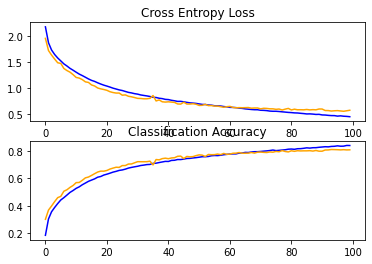

In [26]:
summarize_diagnostics(history, "dropout")

Neste caso, podemos ver um salto na precisão da classificação em cerca de 80%. Revisando a curva de aprendizado do modelo, podemos ver que o overfitting foi resolvido. O modelo converge bem por cerca de 50 ou 60 épocas, ponto em que não há nenhuma melhoria adicional no conjunto de dados de validação.

## Melhorias: Regularização

A regularização envolve a atualização da função de perda para penalizar o modelo em proporção ao tamanho dos pesos do modelo. Isso tem um efeito de regularização, já que pesos maiores resultam em um modelo mais complexo e menos estável, enquanto pesos menores costumam ser mais estáveis e gerais. Adicionamos regularização às camadas convolucionais e às camadas totalmente conectadas definindo o argumento “kernel_regularizer” e especificando o tipo de regularização. Nesse caso, utilizamos a regularização de peso L2, o tipo mais comum usado para redes neurais e um peso padrão sensível de 0,001.

In [27]:
from keras.regularizers import l2
model_regularization = Sequential()
model_regularization.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001), input_shape=(32, 32, 3)))
model_regularization.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model_regularization.add(MaxPooling2D((2, 2)))
model_regularization.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model_regularization.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model_regularization.add(MaxPooling2D((2, 2)))
model_regularization.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model_regularization.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model_regularization.add(MaxPooling2D((2, 2)))
model_regularization.add(Flatten())
model_regularization.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
model_regularization.add(Dense(10, activation='softmax'))
model_regularization.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
history=model_regularization.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/100
313/313 [==============================] - 107s 342ms/step - loss: 3.0572 - accuracy: 0.3174 - val_loss: 2.8199 - val_accuracy: 0.3910
Epoch 2/100
313/313 [==============================] - 98s 312ms/step - loss: 2.7008 - accuracy: 0.4383 - val_loss: 2.6523 - val_accuracy: 0.4478
Epoch 3/100
313/313 [==============================] - 98s 312ms/step - loss: 2.5603 - accuracy: 0.4840 - val_loss: 2.5027 - val_accuracy: 0.5041
Epoch 4/100
313/313 [==============================] - 98s 312ms/step - loss: 2.4388 - accuracy: 0.5245 - val_loss: 2.4222 - val_accuracy: 0.5300
Epoch 5/100
313/313 [==============================] - 98s 312ms/step - loss: 2.3508 - accuracy: 0.5566 - val_loss: 2.3142 - val_accuracy: 0.5696
Epoch 6/100
313/313 [==============================] - 98s 312ms/step - loss: 2.2684 - accuracy: 0.5835 - val_loss: 2.3022 - val_accuracy: 0.5666
Epoch 7/100
313/313 [==============================] - 98s 312ms/step - loss: 2.1928 - accuracy: 0.6042 - val_loss: 2.2905 

Epoch 57/100
313/313 [==============================] - 98s 314ms/step - loss: 0.7270 - accuracy: 1.0000 - val_loss: 2.4122 - val_accuracy: 0.7038
Epoch 58/100
313/313 [==============================] - 98s 313ms/step - loss: 0.7195 - accuracy: 1.0000 - val_loss: 2.3946 - val_accuracy: 0.7043
Epoch 59/100
313/313 [==============================] - 99s 316ms/step - loss: 0.7121 - accuracy: 1.0000 - val_loss: 2.3953 - val_accuracy: 0.7034
Epoch 60/100
313/313 [==============================] - 98s 314ms/step - loss: 0.7047 - accuracy: 1.0000 - val_loss: 2.3839 - val_accuracy: 0.7045
Epoch 61/100
313/313 [==============================] - 98s 314ms/step - loss: 0.6976 - accuracy: 1.0000 - val_loss: 2.3656 - val_accuracy: 0.7055
Epoch 62/100
313/313 [==============================] - 98s 314ms/step - loss: 0.6908 - accuracy: 1.0000 - val_loss: 2.3664 - val_accuracy: 0.7022
Epoch 63/100
313/313 [==============================] - 98s 313ms/step - loss: 0.6839 - accuracy: 1.0000 - val_loss: 2

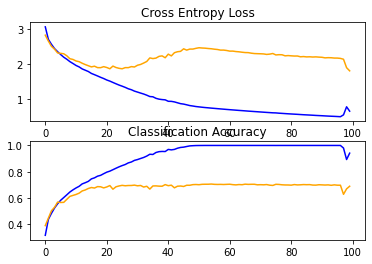

In [29]:
summarize_diagnostics(history, "regularization")

Neste caso, não vemos melhorias no desempenho do modelo no conjunto de validação; na verdade, vemos uma pequena queda no desempenho de cerca de 10%, quando comparado ao modelo que utiliza *dropout*.

Revendo as curvas de aprendizado, vemos uma pequena redução no **overfitting**, mas o impacto não é tão eficaz quanto o *dropout*.

## Melhoria: Dropout + Regularização

In [30]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001), input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/100
313/313 [==============================] - 116s 372ms/step - loss: 3.3199 - accuracy: 0.1882 - val_loss: 3.1329 - val_accuracy: 0.2558
Epoch 2/100
313/313 [==============================] - 114s 364ms/step - loss: 2.9844 - accuracy: 0.3213 - val_loss: 2.9050 - val_accuracy: 0.3538
Epoch 3/100
313/313 [==============================] - 105s 334ms/step - loss: 2.8189 - accuracy: 0.3793 - val_loss: 2.7270 - val_accuracy: 0.4145
Epoch 4/100
313/313 [==============================] - 105s 334ms/step - loss: 2.7131 - accuracy: 0.4104 - val_loss: 2.6099 - val_accuracy: 0.4517
Epoch 5/100
313/313 [==============================] - 105s 334ms/step - loss: 2.6220 - accuracy: 0.4384 - val_loss: 2.5404 - val_accuracy: 0.4738
Epoch 6/100
313/313 [==============================] - 106s 340ms/step - loss: 2.5342 - accuracy: 0.4723 - val_loss: 2.5688 - val_accuracy: 0.4606
Epoch 7/100
313/313 [==============================] - 105s 334ms/step - loss: 2.4814 - accuracy: 0.4884 - val_loss: 2

313/313 [==============================] - 105s 335ms/step - loss: 1.2334 - accuracy: 0.7974 - val_loss: 1.2857 - val_accuracy: 0.7857
Epoch 57/100
313/313 [==============================] - 104s 334ms/step - loss: 1.2206 - accuracy: 0.7999 - val_loss: 1.2799 - val_accuracy: 0.7842
Epoch 58/100
313/313 [==============================] - 104s 334ms/step - loss: 1.2116 - accuracy: 0.8027 - val_loss: 1.2747 - val_accuracy: 0.7858
Epoch 59/100
313/313 [==============================] - 105s 334ms/step - loss: 1.2006 - accuracy: 0.8041 - val_loss: 1.2531 - val_accuracy: 0.7901
Epoch 60/100
313/313 [==============================] - 105s 334ms/step - loss: 1.1820 - accuracy: 0.8067 - val_loss: 1.2504 - val_accuracy: 0.7911
Epoch 61/100
313/313 [==============================] - 105s 335ms/step - loss: 1.1709 - accuracy: 0.8102 - val_loss: 1.2575 - val_accuracy: 0.7854
Epoch 62/100
313/313 [==============================] - 105s 334ms/step - loss: 1.1649 - accuracy: 0.8094 - val_loss: 1.2660 

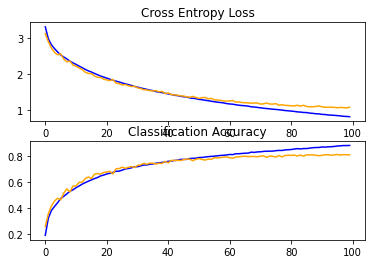

In [32]:
summarize_diagnostics(history, "dropout_regularization")

Exploramos três abordagens projetadas para desacelerar a convergência do modelo.

Um resumo dos resultados é fornecido abaixo:

* Linha de base + *dropout*: 80%
* Linha de base + regularização: 69%
* Linha de base + regularização e *dropout*: 80%

Os resultados sugerem que o dropout estão tendo o efeito desejado, e a regularização, pelo menos para a configuração escolhida, não. A combinação das duas técnicas não apresentou nenhuma melhora significativa em relação ao baseline com três blocos.

## Avaliação no conjunto de teste

A fim de avaliar e poder comparar o desempenho dos modelos optamos por avaliar apenas os seguintes modelos:
* Baseline: 3 bloco da VGG
* Modelo com *Dropout*
* Modelo com *Dropout* + Regularização

Como podemos observar, a acurácia dos modelos reflete o comportamento de cada modelo na etapa de treinamento. O modelo que possui *dropout* possui a maior acurácia entre os três modelos analisados, além de que o modelo com *dropout* e regulariazação possui um resultado muito próximo do modelo com melhor desempenho, então considerando a acurácia e a complexidade de cada modelo podemos dizer que o modelo com três blocos da rede VGG e camadas de *dropout* é o melhor modelo dentre os analisados para essa base de dados.

In [57]:
# Baseline
_, acc_3 = model_vgg3.evaluate(x_test, y_test, verbose=0)
acc_3

0.6937000155448914

In [58]:
# Dropout
_, acc_dropout = model_dropout.evaluate(x_test, y_test, verbose=0)
acc_dropout

0.7996000051498413

In [59]:
# Dropout + Regularização
_, acc = model.evaluate(x_test, y_test, verbose=0)
acc

0.7993000149726868

# Trabalhos futuros

O *Dropout* escolhido apresentou um bom desempenho e não sabemos se a taxa escolhida de 20% é a melhor. Poderíamos explorar outras taxas de *dropout*, bem como diferentes posicionamentos dessas camadas na arquitetura do modelo, e também tentar melhorar o efeito da regularização talvez usando uma ponderação maior, como 0,01 ou mesmo 0,1.

# Evidências AWS

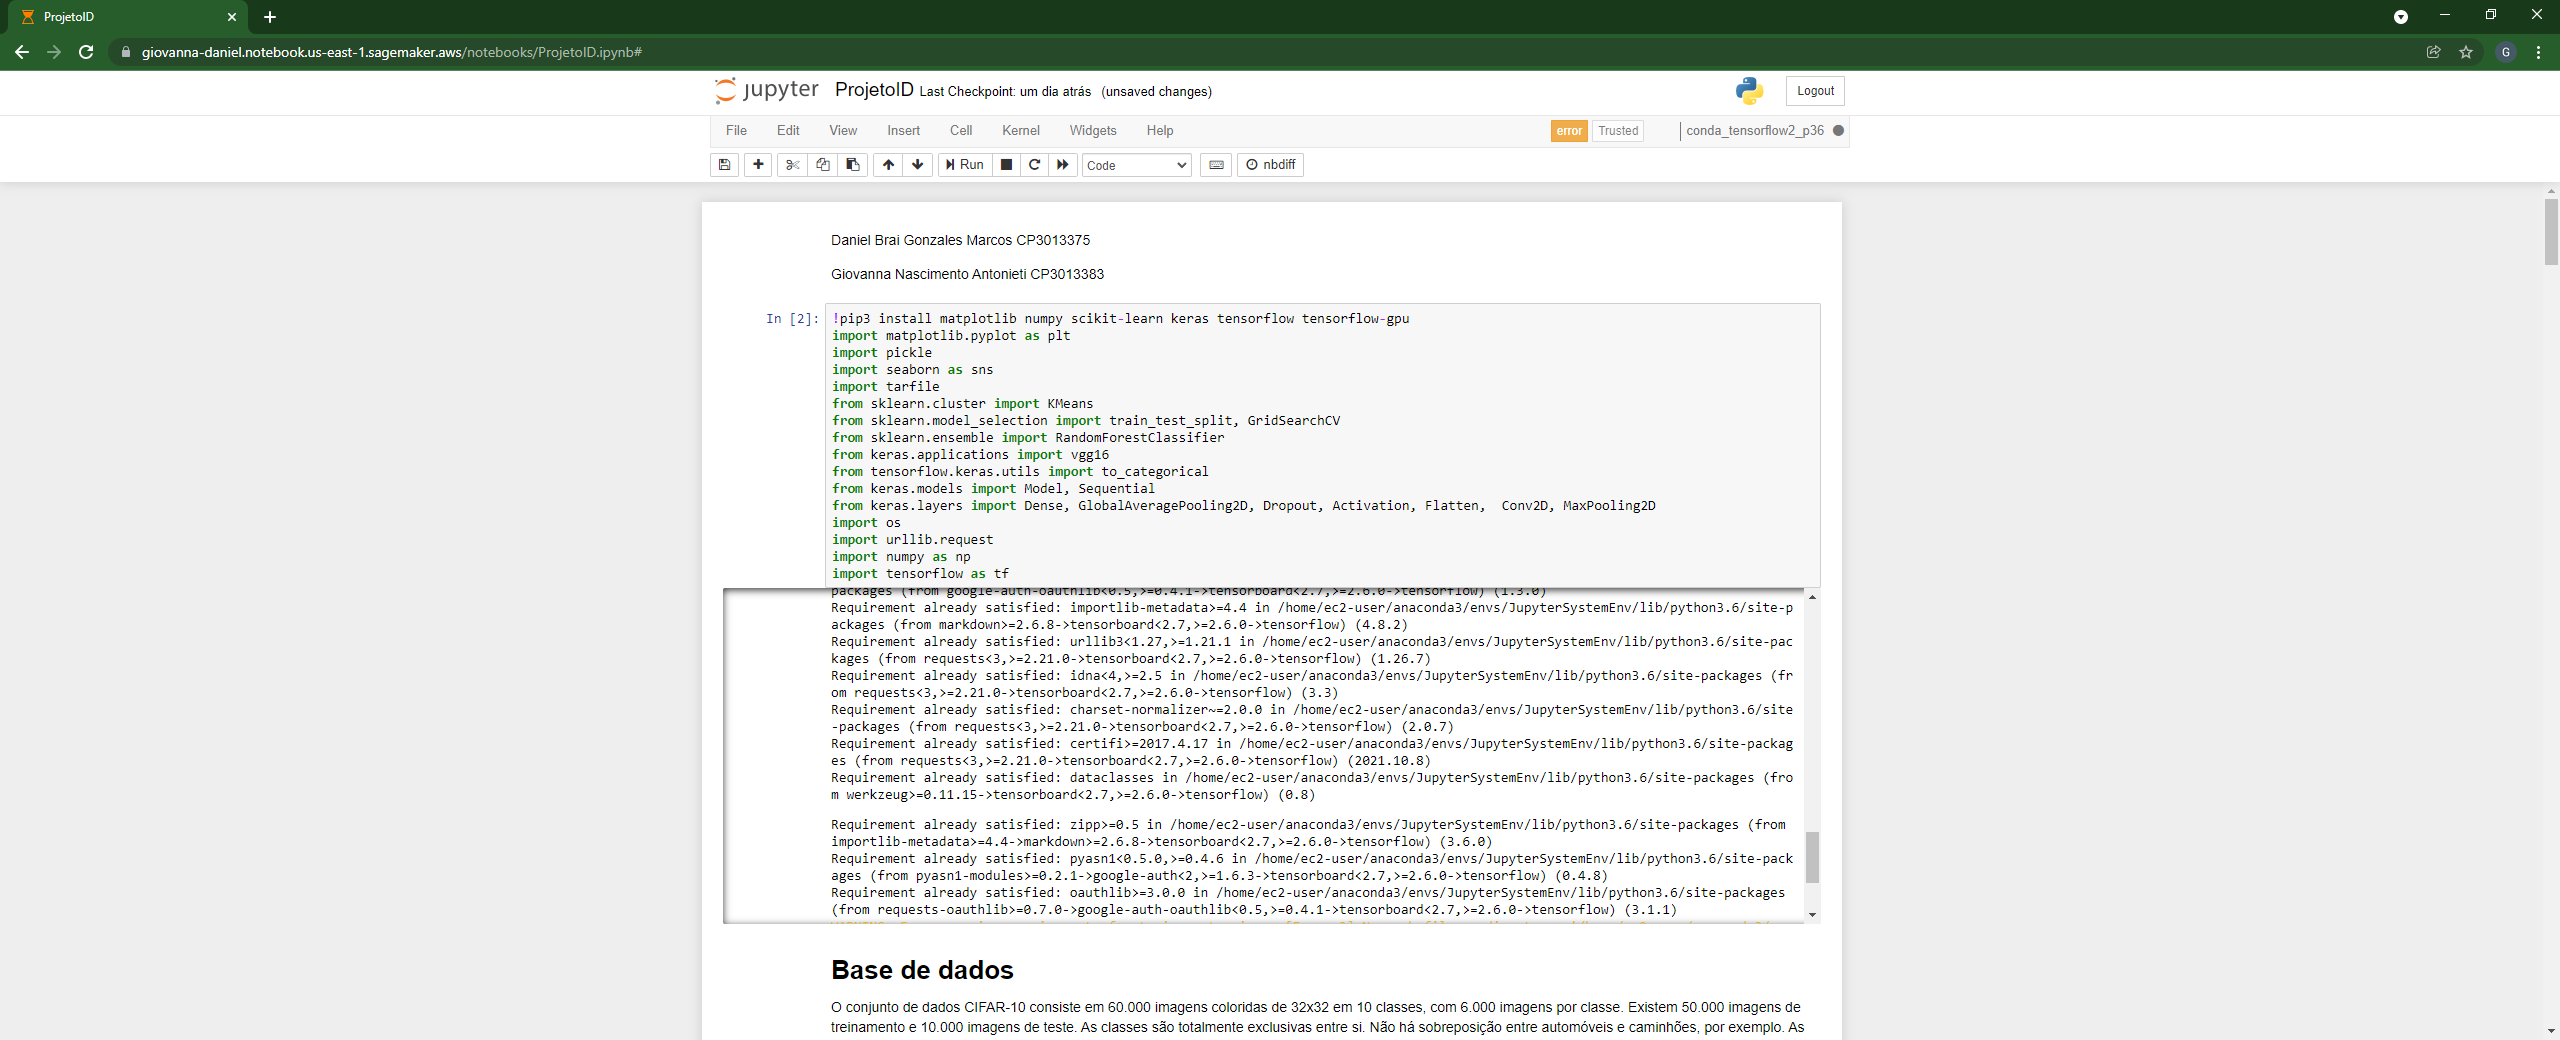

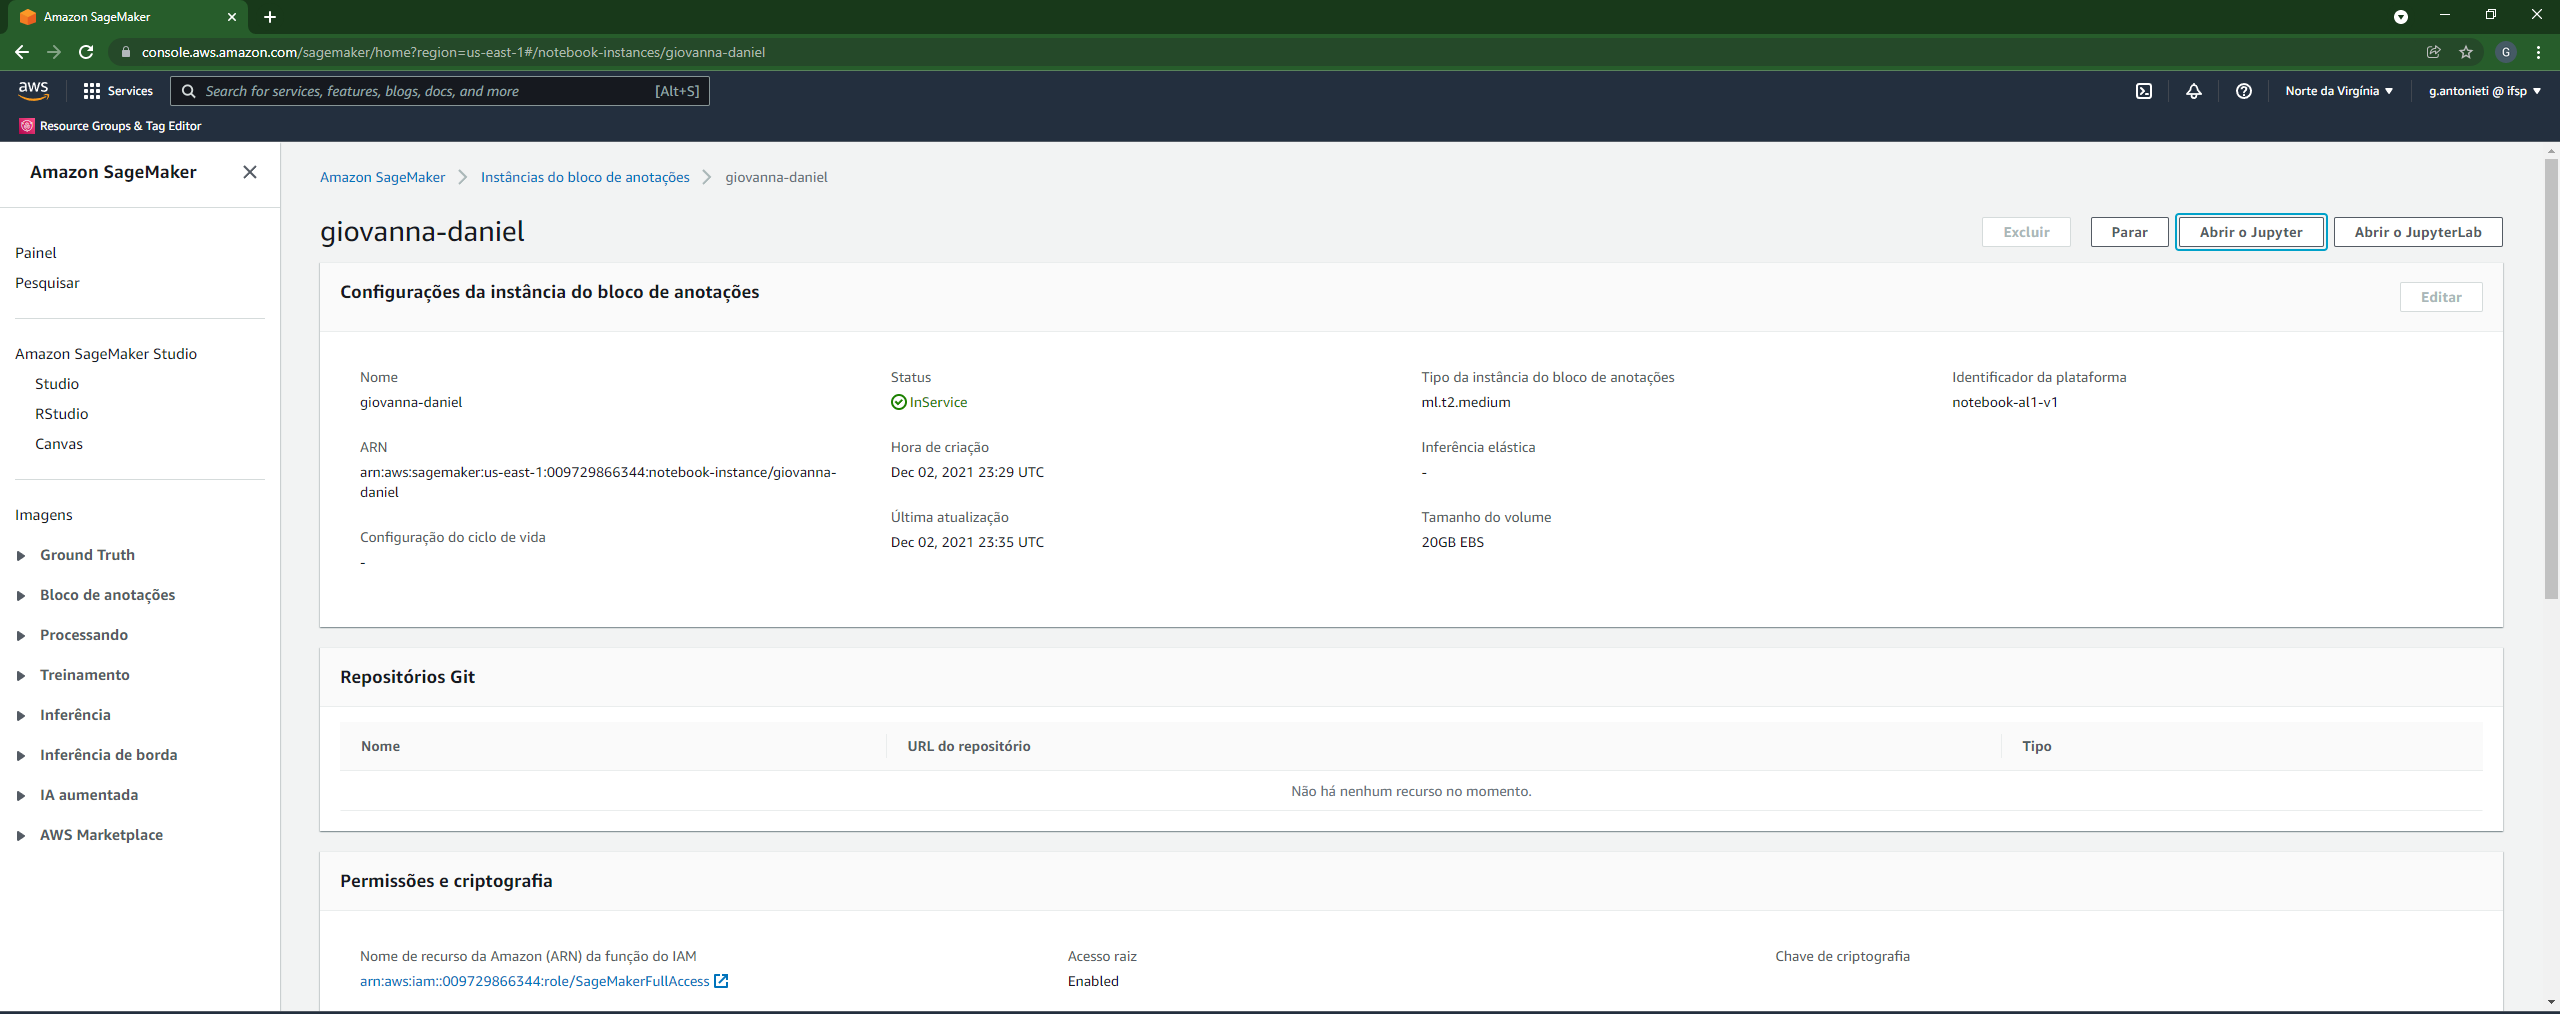